# Disociační křivka molekulárního vodíku - celá
V tomto notebooku je ukázka výpočtu disociační křivky molekulárního vodíku při použití bazického souboru cc-PVZD. Voleno zde bude paritní mapování u kterého je ze znalosti symetrií možné odstranit 2 ze 4 qubitů a urychlit tak výpočet. Výpočet dále urychlíme též využitím tzv. bootstrappingu, kdy vzorkovač (BOPES) využívá optimálních variačních parametrů daného stupně volnosti jako počátečních bodů pro VQE v dalších stupních volnosti.

In [1]:
#version control
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.21.0', 'qiskit-aer': '0.10.4', 'qiskit-ignis': '0.5.2', 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.37.0', 'qiskit-nature': '0.4.3', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
# import common packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

# import qiskit tools
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit import Aer
from qiskit.algorithms.minimum_eigen_solvers import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import ExcitationPreserving
from qiskit import BasicAer
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

# improt qiskit nature tools
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.algorithms.pes_samplers import BOPESSampler

import warnings

warnings.simplefilter("ignore", np.RankWarning)

algorithm_globals.random_seed = 75

Jako klasický driver volíme Psi4 a jako bazický soubor cc-PVZD.

In [3]:
#define the distance which will be regarded as a degree of freedom
distance = partial(Molecule.absolute_distance, atom_pair=(1, 0))

#define the molecule
molecule = Molecule(
    geometry=[("H", [0.0, 0.0, 0.0]), ("H", [0.0, 0.0, 0.3])],
    degrees_of_freedom=[distance],
)

# pass molecule to PSI4 driver with sto3g basis
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="cc-pvdz", driver_type=ElectronicStructureDriverType.PSI4
)

Zde můžeme vidět, jak vypadá fermionový operátor v druhém kvantování. Musíme zde však uvážit celkovou náročnost simulace při použití cc-PVZD souboru a využít tak ActiveSpaceTransformer. Ten vybere zadaný počet (zde 4) nejdůležitějších MO (běžně se jedná o MO v okolí Fermiho hladiny). Celkový počet qubitů je pak vzhledem ke dvoum možným spinům vynásoben dvěma (zde tedy 8).

In [6]:
#define eloctronic structure problem
transformer = ActiveSpaceTransformer(
    num_electrons=2, #how many electrons we have in our active space
    num_molecular_orbitals=4, #how many orbitals we have in our active space
)

es_problem = ElectronicStructureProblem(driver, [transformer])
second_q_op = es_problem.second_q_ops()
print(second_q_op[0])

Fermionic Operator
register length=8, number terms=300
  -1.606866183545049 * ( +_0 -_0 )
+ -0.16376080146174382 * ( +_0 -_2 )
+ -0.4477994476238284 * ( +_1 -_1 )
+ -0.16376080146174385 * ( +_2 -_0 )
+ -0.4485087785965225 * ( +_2 -_2 )
+ 0.02354934246 ...


Použijeme paritní mapování:

In [7]:
#Parity mapping with reduction
qubit_converter = QubitConverter(mapper=ParityMapper())
qubit_op = qubit_converter.convert(second_q_op[0])
print(qubit_op)

0.5773575652082534 * IIIIIIII
- 0.12738234178634683 * IIIIIIIZ
- 0.0372378893515163 * IIIIIZXX
- 0.0372378893515163 * IIIIIIYY
- 0.35114114031424326 * IIIIIIZZ
- 0.4116606585279145 * IIIIIZZI
- 0.9269859582295947 * IIIIZZII
- 0.12738234178634703 * IIIZZIII
- 0.03723788935151631 * IZXXZIII
- 0.03723788935151631 * IIYYIIII
- 0.35114114031424326 * IIZZIIII
- 0.41166065852791456 * IZZIIIII
- 0.9269859582295947 * ZZIIIIII
+ 0.08584958205552126 * IIIIIIZI
+ 0.09480231122402619 * IIIIIZZZ
+ 0.1501334224937059 * IIIIZZIZ
- 0.009788218226172759 * IIIIIZYY
- 0.009788218226172759 * IIIIIIXX
+ 0.025647908009963933 * IIIIZIXX
+ 0.025647908009963933 * IIIIZZYY
+ 0.20948957077725158 * IIIZZIIZ
+ 0.040940200412151746 * IIIZZZXX
+ 0.040940200412151746 * IIIZZIYY
+ 0.005824762547412009 * IIZXZIZX
- 0.005824762547412009 * IIIXIIZX
- 0.005824762547412009 * IIZXZIIX
+ 0.005824762547412009 * IIIXIIIX
+ 0.04094020041215175 * IZXXZIIZ
+ 0.04094020041215175 * IIYYIIIZ
+ 0.01646721463133705 * IZXXZZXX
+ 0.01646

V dalším definujeme úlohu a jako backend použijeme StatevectorSimulator.

In [8]:
#define quantum instance (using statevector simulator)
quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))
solver = VQE(quantum_instance=quantum_instance)
gsc = GroundStateEigensolver(qubit_converter, solver)

Úlohu budeme počítat v 10 ekvidistantně rozmístěných bodech pro vzdálenosti jader v rozmezí 0,2 až 2 Ångströmy. Ke vzorkování se použije třída BOPESSampler sloužící k vyhodnocení PES při Born-Oppenheimrově aproximaci. Bootstrapping volíme jako True.

In [9]:
# Specify degree of freedom (points of interest)
points = np.linspace(0.2, 2, 10) #equidistantly distributes 10 points in given range
results_full = {}  # full dictionary of results for each condition
results = {}  # dictionary of (point,energy) results for each condition

# define instance to sampler
bs = BOPESSampler(gsc, bootstrap=True, num_bootstrap=None, extrapolator=None)

# execute
res = bs.sample(es_problem, points)
results_full[f"VQE"] = res.raw_results
results[f"points_"] = res.points
results[f"energies_"] = res.energies

Pro srovnání použijeme klasické řešení:

In [10]:
#compare to classical eigensolver
# define numpy solver
solver_numpy = NumPyMinimumEigensolver()
me_gsc_numpy = GroundStateEigensolver(qubit_converter, solver_numpy)
bs_classical = BOPESSampler(me_gsc_numpy, bootstrap=False, num_bootstrap=None, extrapolator=None)

# execute
res_np = bs_classical.sample(es_problem, points)
results_full["np"] = res_np.raw_results
results["points_np"] = res_np.points
results["energies_np"] = res_np.energies

Energie v jednotlivých bodech z VQE:

In [11]:
print(results[f"energies_"])

[(0.4939601007458503+0j), (-0.6166667288935881+0j), (-0.8705197407324557+0j), (-0.9495803379163372+0j), (-0.9780811967689603+0j), (-0.9882339426576832+0j), (-0.9906013889291293+0j), (-0.9898746912127826+0j), (-0.9867334585609999+0j), (-0.9850273564809602+0j)]


Energie v jednotlivých bodech klasicky:

In [12]:
print(results["energies_np"])

[(0.1232345082265005+0j), (-0.9269315463989791+0j), (-1.1239874226725566+0j), (-1.1495769898001378+0j), (-1.1295449523721945+0j), (-1.0986802335291157+0j), (-1.0689136094326663+0j), (-1.0446836755246118+0j), (-1.0272781978889076+0j), (-1.0157741593004987+0j)]


Výsledky vykreslíme v grafu:

Text(0, 0.5, 'Energy')

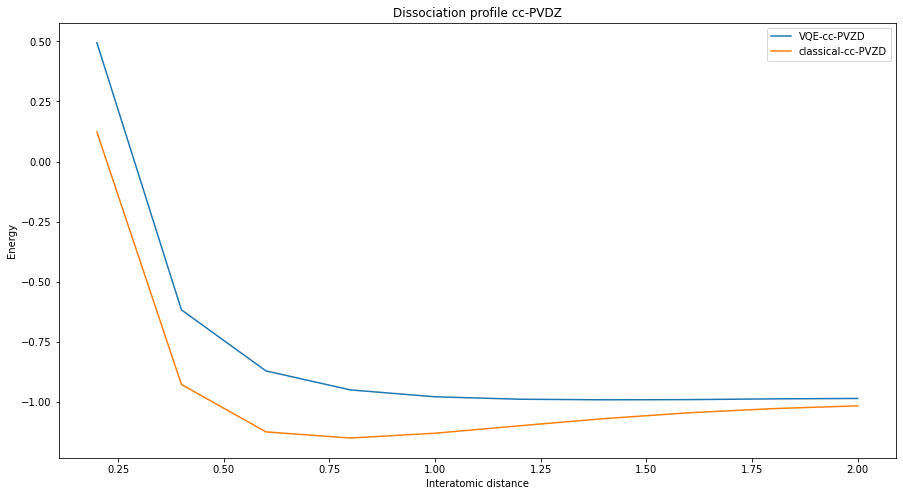

In [26]:
fig = plt.figure(figsize=(15, 8))

plt.plot(results[f"points_"], results[f"energies_"], label=f"VQE-cc-PVZD")
plt.plot(results["points_np"], results["energies_np"], label="classical-cc-PVZD")
plt.legend()
plt.title("Dissociation profile cc-PVDZ")
plt.xlabel("Interatomic distance")
plt.ylabel("Energy")


Počet vyhodnocení:

In [14]:
for condition, result_full in results_full.items():
    if condition != "np":
        print("Total evaluations: ")
        sum = 0
        for key in result_full:
            sum += result_full[key].raw_result.cost_function_evals  
        else:
            continue
    print(sum)

Total evaluations: 
3311


In [ ]:
# This code is a modification of Qiskit code licensed under the Apache License, Version 2.0.